[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MatteoFalcioni/Learning-LangGraph/blob/main/notebooks/8_human_in_the_loop.ipynb)

### Setup

#### Install requirements

In [ ]:
%pip install -q -U -r https://raw.githubusercontent.com/MatteoFalcioni/Learning-LangGraph/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### local (notebooks or files)

In [ ]:
from dotenv import load_dotenv
load_dotenv()  # load api keys

True

#### Colab

In [ ]:
from google.colab import userdata
import os

REQUIRED_KEYS = [
    'OPENAI_API_KEY',
    'LANGSMITH_TRACING',
    'LANGSMITH_ENDPOINT',
    'LANGSMITH_API_KEY',
    'LANGSMITH_PROJECT'
]

def _set_colab_keys(key : str):
    # Retrieve the secret value using its key/name
    secret_value = userdata.get(key)
    # set it as a standard OS environment variable
    os.environ[key] = secret_value

for key in REQUIRED_KEYS:
    _set_colab_keys(key)

ModuleNotFoundError: No module named 'google.colab'

# Human In The Loop & Time Travel

---
*References:*
- https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#enable-human-intervention

- https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/#use-time-travel
---

In this notebook we'll go through 2 important notions related to **interrupting and resuming our graph workflow**: 
1. *Dynamic Interrupts*. These allow us to implement **human-in-the-loop** in our workflows, i.e. dynamical human intervention in our graph to aprove routing / review tool usage / review state updates.  
2. *Time Travel*. We saw how we can resume conversations using `thread_id`'s. Time travel is more specific than that: it allows us to go back to a specific checkpoint (a specific node execution) in memory.

## 1. Dynamic Interrupts - the `interrupt` primitive


Motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

We will introduce [*dynamic interrupts*](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#pause-using-interrupt), which are *the recommended way* of pausing graph workflows; they are internally managed by the graph, based on its current state.

There also exist static breakpoints, or [*static interrupts*](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#debug-with-interrupts). This is an approach that is explicitly *not recommended for human-in-the-loop workflows*, and recommended instead for debugging or testing. For this reason, we will not go over it.

The workflow to use dynamic interrupts can be summarized as: **we must couple an `interrupt` primitive to stop our graph and a `Command.resume` to restart it**.

### 1.1 Example

To use `interrupt`, we must:

1. Specify a checkpointer to save the graph state after each step.
2. Call `interrupt()` in the appropriate place (we'll see how) 
3. Run the graph with a thread ID until the interrupt is hit.
4. Resume execution using invoke/stream (using the `Command` primitive).


Let's see an example direclt from LangGraph API's documentation:

In [ ]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph

from langgraph.types import interrupt, Command


class State(TypedDict):
    some_text: str


def human_node(state: State):
    value = interrupt(      # interrupt(...) pauses execution at human_node, surfacing the given payload to a human.
        {
            "text_to_revise": state["some_text"]  
        }
    )
    return {
        "some_text": value  
    }


# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")
checkpointer = InMemorySaver()  # memory
graph = graph_builder.compile(checkpointer=checkpointer)
# Pass a thread ID to the graph to run it.
config = {"configurable": {"thread_id": uuid.uuid4()}}
# Run the graph until the interrupt is hit.
result = graph.invoke({"some_text": "original text"}, config=config)  


When the graph hits the interrupt, it returns an Interrupt object with the payload and metadata:

In [2]:
print(result['__interrupt__']) 

[Interrupt(value={'text_to_revise': 'original text'}, id='2dd75cb41471915a7198035cfde2c1af')]


> **Note:** Interrupts resemble Python's `input()` function in terms of developer experience, but they do not automatically resume execution from the interruption point. Instead, they rerun the entire node where the interrupt was used. For this reason, interrupts are typically best placed at the start of a node or in a dedicated node.

To resume execution, use the `Command` primitive, which can be supplied via the `invoke` or `stream` methods. 

The graph resumes execution from the beginning of the node where `interrupt(...)` was initially called. 

This time, the interrupt function will return the value provided in `Command(resume=value)` rather than pausing again. 

All code from the beginning of the node to the interrupt will be re-executed.

In [3]:
print(graph.invoke(Command(resume="Edited text"), config=config)) 

{'some_text': 'Edited text'}


In [4]:
graph.get_state(config=config)

StateSnapshot(values={'some_text': 'Edited text'}, next=(), config={'configurable': {'thread_id': '65a605be-5c86-40ec-980a-823c6c98083c', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7482-bbce-6ab1-8001-8b4a69b51ada'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-12T10:49:01.990301+00:00', parent_config={'configurable': {'thread_id': '65a605be-5c86-40ec-980a-823c6c98083c', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7481-f759-6783-8000-d5453f4a74aa'}}, tasks=(), interrupts=())

### 1.2. Resume multiple interrupts with one invocation

When nodes with interrupt conditions are run in parallel, it's possible to have multiple interrupts in the task queue.

Once your graph has been interrupted and is stalled, you can resume all the interrupts at once with `Command.resume`, passing a dictionary mapping of interrupt ids to resume values.

In [5]:
from typing import TypedDict
import uuid
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    text_1: str
    text_2: str


def human_node_1(state: State):
    value = interrupt({"text_to_revise": state["text_1"]})
    return {"text_1": value}


def human_node_2(state: State):
    value = interrupt({"text_to_revise": state["text_2"]})
    return {"text_2": value}


graph_builder = StateGraph(State)
graph_builder.add_node("human_node_1", human_node_1)
graph_builder.add_node("human_node_2", human_node_2)

# Add both nodes in parallel from START
graph_builder.add_edge(START, "human_node_1")
graph_builder.add_edge(START, "human_node_2")

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

thread_id = str(uuid.uuid4())
config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
result = graph.invoke(
    {"text_1": "original text 1", "text_2": "original text 2"}, config=config
)

graph.get_state(config=config)

StateSnapshot(values={'text_1': 'original text 1', 'text_2': 'original text 2'}, next=('human_node_1', 'human_node_2'), config={'configurable': {'thread_id': '2ea53065-e607-4990-90ce-19b28e88c1e6', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7483-07e9-61d8-8000-bcf66c602332'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-12T10:49:09.970355+00:00', parent_config={'configurable': {'thread_id': '2ea53065-e607-4990-90ce-19b28e88c1e6', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7483-07e5-6dd0-bfff-e1f8de2fab6a'}}, tasks=(PregelTask(id='62a6babc-ecfe-6ffc-dcc4-98964c466c4f', name='human_node_1', path=('__pregel_pull', 'human_node_1'), error=None, interrupts=(Interrupt(value={'text_to_revise': 'original text 1'}, id='a8b198cd0b4a6dab6236848c6c801f50'),), state=None, result=None), PregelTask(id='9d07f82d-a702-6cc8-c3e9-5add3a50521b', name='human_node_2', path=('__pregel_pull', 'human_node_2'), error=None, interrupts=(Interrupt(value={'text_to_revise': 'original te

In [6]:
# Resume with mapping of interrupt IDs to values
resume_map = {
    i.id: f"human input for {i.value}"
    for i in graph.get_state(config=config).interrupts
}
print(graph.invoke(Command(resume=resume_map), config=config))

{'text_1': "human input for {'text_to_revise': 'original text 1'}", 'text_2': "human input for {'text_to_revise': 'original text 2'}"}


In [7]:
graph.get_state(config=config)

StateSnapshot(values={'text_1': "human input for {'text_to_revise': 'original text 1'}", 'text_2': "human input for {'text_to_revise': 'original text 2'}"}, next=(), config={'configurable': {'thread_id': '2ea53065-e607-4990-90ce-19b28e88c1e6', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7483-270a-631d-8001-953f7f249af2'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-12T10:49:13.234493+00:00', parent_config={'configurable': {'thread_id': '2ea53065-e607-4990-90ce-19b28e88c1e6', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7483-07e9-61d8-8000-bcf66c602332'}}, tasks=(), interrupts=())

### 1.3 Common patterns 

Below we show different design patterns that can be implemented using `interrupt` and `Command`

#### Approval or rejection

<img src="images/interrupt1.png" width="800">


Pause the graph before a critical step, such as an API call, to review and approve the action. 

If the action is rejected, you can prevent the graph from executing the step, and potentially take an alternative action.

In [ ]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='d242f311881ea6ab0a793e858732025f')]


In [ ]:
inter_value = result['__interrupt__'][0].value

print(inter_value)
print()

print(f"Graph interrupted with the question: {inter_value['question']} \nOutput: {inter_value['llm_output']}. \nPossible decisions: 'approve' or 'reject'")

In [ ]:
# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


#### Review and edit state

<img src="images/interrupt2.png" width="800">


In [ ]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph until it hits the interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# Output interrupt payload
print(result["__interrupt__"])

[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, id='22c3961634854968307dda2c89db74f6')]


In [ ]:
# Resume the graph with human-edited input
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)

✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


#### Review tool calls

<img src="images/interrupt3.png" width="800">

To add a human approval step to a tool:

1. Use `interrupt()` in the tool to pause execution.
2. Resume with a `Command` to continue based on human input.

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import tool
from langgraph.types import interrupt
from langchain.agents import create_agent

# An example of a sensitive tool that requires human review / approval
@tool
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

agent = create_agent(
    model="openai:gpt-4o",
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

Stream the agent output, passing the config object to specify the thread ID.

It will run until reaching interruption:

In [ ]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GkVnN8Bb0KUwOM1byMULZNaj', 'function': {'arguments': '{"hotel_name":"McKittrick hotel"}', 'name': 'book_hotel'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 52, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCNV5HgHGunOmU9vcvobMBgKfVl9T', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1f0b13b3-72c4-41f1-9f16-6c40c5b78b45-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'call_GkVnN8Bb0KUwOM1byMULZNaj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 20, 

Resume the agent with a `Command` to continue based on human input.

In [ ]:
from langgraph.types import Command

for chunk in agent.stream(
    Command(resume={"type": "accept"}),  
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at McKittrick hotel.', name='book_hotel', id='42e0e213-685a-4bf3-8e07-421c1ef525dc', tool_call_id='call_GkVnN8Bb0KUwOM1byMULZNaj')]}}


{'agent': {'messages': [AIMessage(content='Your stay at McKittrick Hotel has been successfully booked.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 92, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCNV6tY9hHYty3LxnzBqjMXP5g3GI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a0cbc5cf-9bd9-4d2d-992a-7df07151c5d9-0', usage_metadata={'input_tokens': 92, 'output_tokens': 14, 'total_tokens': 106, 'input_token_details'

# 2. Time Travel

When working with non-deterministic systems that make model-based decisions (e.g., agents powered by LLMs), it can be useful to examine their decision-making process in detail:

- 🤔 Understand reasoning: Analyze the steps that led to a successful result.
- 🐞 Debug mistakes: Identify where and why errors occurred.
- 🔍 Explore alternatives: Test different paths to uncover better solutions.

LangGraph provides time travel functionality to support these use cases. Specifically, you can resume execution from a prior checkpoint — either replaying the same state or modifying it to explore alternatives. 

In all cases, resuming past execution produces a new fork in the history.

### 2.1 How to Time Travel

To use time-travel in LangGraph:

1. Run the graph with initial inputs using `invoke` or `stream` methods.

2. Identify a checkpoint in an existing thread: Use the `get_state_history()` method to retrieve the execution history for a specific `thread_id` and locate the desired `checkpoint_id`.
Alternatively, set an `interrupt` before the node(s) where you want execution to pause. You can then find the most recent checkpoint recorded up to that interrupt.

3. Update the graph state (optional): Use the `update_state` method to modify the graph's state at the checkpoint and resume execution from alternative state.

4. Resume execution from the checkpoint: Use the invoke or stream methods with an input of None and a configuration containing the appropriate `thread_id` and `checkpoint_id`.

### 2.2 Example

This example is taken directly from the LangGraph guide. 

It builds a simple LangGraph workflow that generates a joke topic and writes a joke using an LLM. It demonstrates how to run the graph, retrieve past execution checkpoints, optionally modify the state, and resume execution from a chosen checkpoint to explore alternate outcomes.

#### Setup

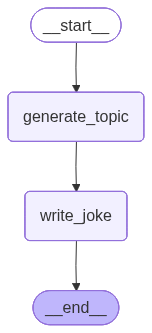

In [8]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]

llm = init_chat_model(
    "openai:gpt-4o",
    temperature=0,
)


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = llm.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

#### 1. Run the graph

In [9]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

How about a joke about the unexpected challenges of working from home? For example, "Why did the laptop apply for a job at the zoo? It wanted to work remotely, but not from the jungle of my living room!"

Why did the cat start attending virtual meetings? It wanted to remind everyone who's really in charge of the home office!


#### 2. Identify a chechkpoint

In [10]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0d7496-11fa-62e0-8002-994cd258192c

('write_joke',)
1f0d7496-00b1-672c-8001-8be21b1fe218

('generate_topic',)
1f0d7495-e96a-6291-8000-33ab09a0b1a6

('__start__',)
1f0d7495-e967-6199-bfff-cd0b06894226



In [11]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'How about a joke about the unexpected challenges of working from home? For example, "Why did the laptop apply for a job at the zoo? It wanted to work remotely, but not from the jungle of my living room!"'}


#### 3. Update the state (optional)

`update_state` will create a new checkpoint. The new checkpoint will be associated with the same thread, but a new checkpoint ID.

In [12]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': '78815b36-1327-4881-a44b-86d404f10bac', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7496-125a-64a0-8002-07b6d19a7947'}}


#### 4. Resume execution from the checkpoint

In [13]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken join a band? Because it had the drumsticks!'}

---


Find exercises for this chapter in [notebook 9.5](./9.5_exercises.ipynb)